In [17]:
# Post Processing Notebook

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score

from pathlib import Path
import numpy as np
import pandas as pd
import random, getopt, os, sys, json

import matplotlib.pyplot as plt
import matplotlib.patches as patches

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

from Lamp.AttrDict.AttrDict import *
from Lamp.Model.Dataloader import *
from Lamp.Model.BaseModel import *
from Lamp.Model.ResNet import *
from Lamp.preprocessing.preprocessing import Image_Raw, Custom, Otsu, disk, Erosion, Mask, Labelize, Closing, Dilation, Rescale_Intenstiy, define_regions

In [4]:
# Model prediciton
def load_config(cfg_path):
    """  """
    if os.path.splitext(cfg_path)[-1] == '.json':
        return AttrDict.from_json_path(cfg_path)
    elif os.path.splitext(cfg_path)[-1] in ['.yaml', '.yml']:
        return AttrDict.from_yaml_path(cfg_path)
    else:
        raise ValueError(f"Unsupported config file format. Only '.json', '.yaml' and '.yml' files are supported.")

def resnet(layers=[3, 4, 6, 3],channels=3, num_classes=1000):
    model = ResNet(BasicBlock,layers,channels=channels,num_classes=num_classes)
    return model

class Classifier(BaseModelSingle):
    def __init__(self, net: nn.Module, opt: Optimizer = None, sched: _LRScheduler = None, 
        logger: Logger = None, print_progress: bool = True, device: str = 'cuda:0', **kwargs):
        super().__init__(net, opt=opt, sched=sched, logger=logger, print_progress=print_progress, device=device, **kwargs)

    def forward_loss(self, data: Tuple[Tensor]) -> Tensor:
        """  """
        pass

    def predict(self, loader):
        """  """
        labels = []
        self.net.eval()
        with torch.no_grad():
            for b, data in enumerate(loader):
                input = data
                input = input.to(self.device)

                output = self.net(input)
                pred = torch.argmax(output, dim=1)

                labels.append(pred.cpu().data.tolist())
        return labels

class Dataset(data.Dataset):
    def __init__(self,image_raw,transforms):
        self.image_raw = image_raw
    
        self.transform = transforms
    
    def __len__(self):
        return len(self.image_raw.regions)

    def __getitem__(self,idx):

        im = Image.fromarray(image_raw.regions[idx]['mar']['new'])
        im = self.transform(im)

        return im

# Transforms (other than MinMaxNorm and ToTensor)
dict_transform = {
    "Padding":Padding,
    "VerticalFlip":tf.RandomVerticalFlip,
    "HorizontalFlip":tf.RandomHorizontalFlip,
    "Rotation":tf.RandomRotation,
    "CenterCrop":tf.CenterCrop,
    "Resize":tf.Resize,
    }

dict_ = {0:'BL',1:'GN',2:'ML',3:'MS',4:'OL'}

In [5]:
root_load = 'E:/FileHistory/nilso/LAPTOP-154DU0LI/Data/C/Users/nilso/Documents/EPFL/MA4/PDS Turberg/'
folder_to_load = 'Cuttings_data/ML-DB-Geo1/'
train_tiffs = os.listdir(os.path.dirname(root_load + folder_to_load))
tiff = train_tiffs[400]
file_path = root_load + folder_to_load + tiff

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'E:/FileHistory/nilso/LAPTOP-154DU0LI/Data/C/Users/nilso/Documents/EPFL/MA4/PDS Turberg/Cuttings_data/ML-DB-Geo1'

In [6]:
image_raw = Image_Raw(file_path,'unchanged')

# First
Custom().apply(image = image_raw, thres = Otsu().return_threshold(image_raw))

# Second 
selem = disk(2)
Erosion(selem=selem).apply(image_raw)

# Third
Mask().apply(image_raw)
Labelize().apply(image_raw,threshold=5000)

# Fourth
selem = disk(5)
Closing(selem=selem).apply_regions(image_raw)

# Fifth
selem = disk(2)
Erosion(selem=selem).apply(image_raw, 3)

# Sixth
Mask().apply(image_raw)
Labelize().apply(image_raw,threshold=5000)

# Seventh
selem = disk(2)
Dilation(selem=selem).apply(image_raw,4)

# Eigth
Rescale_Intenstiy().apply_regions(image_raw, in_range=(1,99), out_range = (0,1), background=False)

define_regions(image_raw)

NameError: name 'file_path' is not defined

In [7]:
ifile = '../Models/config/MAR_RESNET18_PADDED_256_ALL_NEW.yaml'

inputs = load_config(ifile)

layers = inputs.Model.Layers # [3, 4, 6, 3] for ResNet34 and [2, 2, 2, 2] for ResNet18
classes = inputs.Model.OutClasses
channels = inputs.Model.Channels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
path_model = f"{root_path}/{inputs.PathSave}/{inputs.ModelName}"

model_name = f"model_all.pt"
save_model_path = f"{path_model}/{model_name}"

transforms_test = Transforms(
    [dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTest.items()] 
    )

# Change dataset
testDataset = Dataset(
    image_raw,
    transforms=transforms_test.get_transforms()
    )

test_dataloader = torch.utils.data.DataLoader(
    testDataset, 
    shuffle=False,
    batch_size=1
    )

net = resnet(layers=layers,channels=channels,num_classes=classes)

classifier = Classifier(
                net=net, 
                device=device
                )

classifier.load(save_model_path)

pred = classifier.predict(test_dataloader)

NameError: name 'image_raw' is not defined

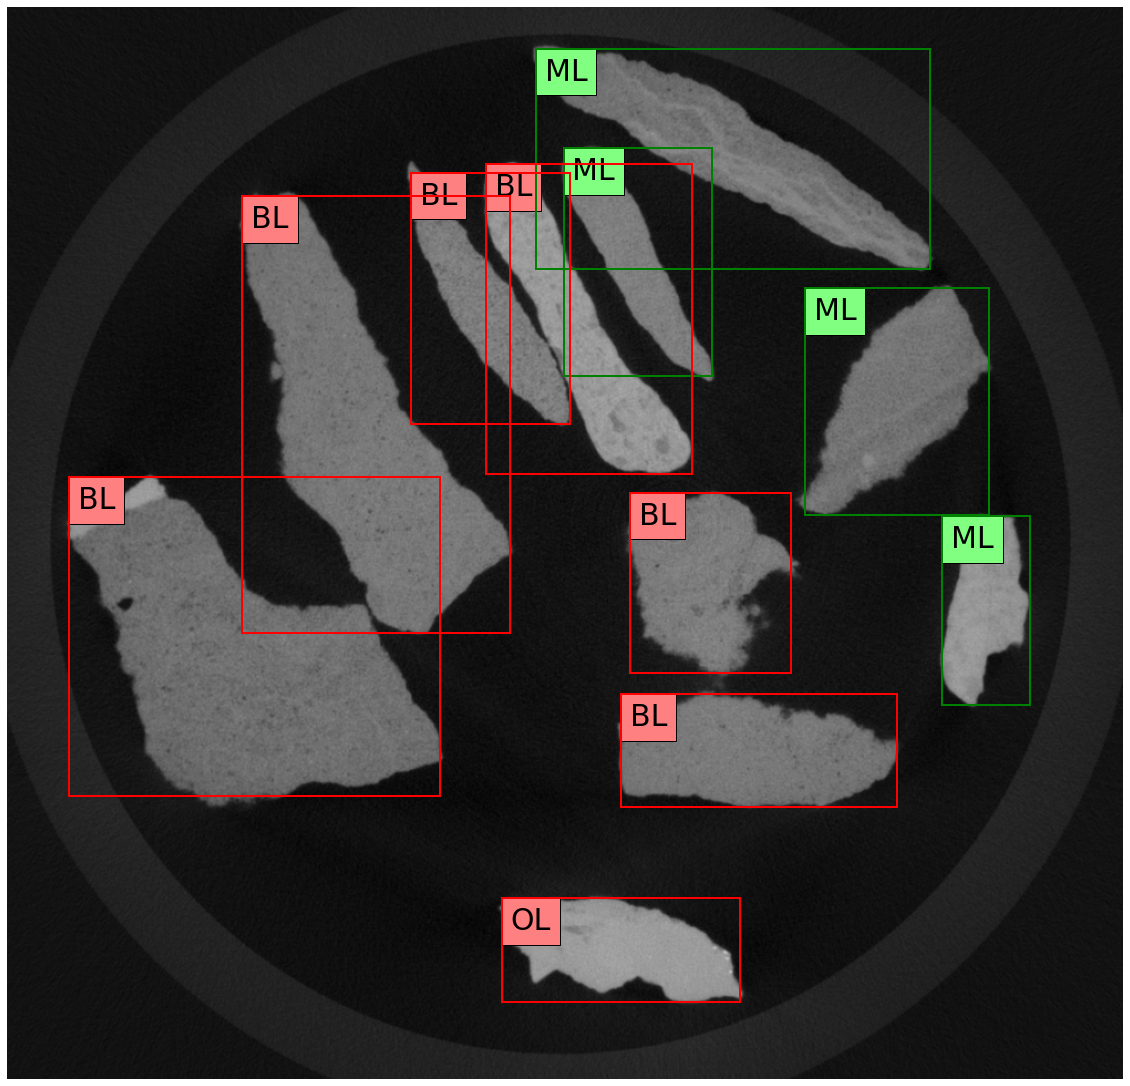

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(image_raw.img,cmap='gray')
ax.axis(False)

for i_, region_i in enumerate(image_raw.regions):
    box = region_i['bbox']['box']
    if pred[i_][0] == 2:
        poly = patches.Polygon(box,fill=False, edgecolor='green', linewidth=2)
        fc = (0.5, 1, 0.5)
    else :
        poly = patches.Polygon(box,fill=False, edgecolor='red', linewidth=2)
        fc = (1, 0.5, 0.5)
    
    ax.text(
        x=box[0,0] + 8,
        y=box[0,1] + 8,
        s=dict_[pred[i_][0]],
        zorder=0.5,
        size=30,
        ha="left",
        va="top",
        bbox=dict(
            boxstyle="square",
            fc=fc
            )
        )
    ax.add_patch(poly)

In [8]:
root_load = 'E:/FileHistory/nilso/LAPTOP-154DU0LI/Data/C/Users/nilso/Documents/EPFL/MA4/PDS Turberg/'
folder_to_load = 'Cuttings_data/ML3-3-DL/'
train_tiffs = os.listdir(os.path.dirname(root_load + folder_to_load))
tiff = train_tiffs[990]
file_path = root_load + folder_to_load + tiff

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'E:/FileHistory/nilso/LAPTOP-154DU0LI/Data/C/Users/nilso/Documents/EPFL/MA4/PDS Turberg/Cuttings_data/ML3-3-DL'

In [10]:
image_raw = Image_Raw(file_path,'unchanged')

# First
Custom().apply(image = image_raw, thres = Otsu().return_threshold(image_raw))

# Second 
selem = disk(2)
Erosion(selem=selem).apply(image_raw)

# Third
Mask().apply(image_raw)
Labelize().apply(image_raw,threshold=5000)

# Fourth
selem = disk(5)
Closing(selem=selem).apply_regions(image_raw)

# Fifth
selem = disk(2)
Erosion(selem=selem).apply(image_raw, 3)

# Sixth
Mask().apply(image_raw)
Labelize().apply(image_raw,threshold=5000)

# Seventh
selem = disk(2)
Dilation(selem=selem).apply(image_raw,4)

# Eigth
Rescale_Intenstiy().apply_regions(image_raw, in_range=(1,99), out_range = (0,1), background=False)

define_regions(image_raw)

NameError: name 'file_path' is not defined

In [11]:
ifile = '../Models/config/MAR_RESNET34_PADDED_256_ALL_NEW.yaml'

inputs = load_config(ifile)

layers = inputs.Model.Layers # [3, 4, 6, 3] for ResNet34 and [2, 2, 2, 2] for ResNet18
classes = inputs.Model.OutClasses
channels = inputs.Model.Channels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
path_model = f"{root_path}/{inputs.PathSave}/{inputs.ModelName}"

model_name = f"model_all.pt"
save_model_path = f"{path_model}/{model_name}"

transforms_test = Transforms(
    [dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTest.items()] 
    )

# Change dataset
testDataset = Dataset(
    image_raw,
    transforms=transforms_test.get_transforms()
    )

test_dataloader = torch.utils.data.DataLoader(
    testDataset, 
    shuffle=False,
    batch_size=1
    )

net = resnet(layers=layers,channels=channels,num_classes=classes)

classifier = Classifier(
                net=net, 
                device=device
                )

classifier.load(save_model_path)

pred = classifier.predict(test_dataloader)

NameError: name 'image_raw' is not defined

NameError: name 'image_raw' is not defined

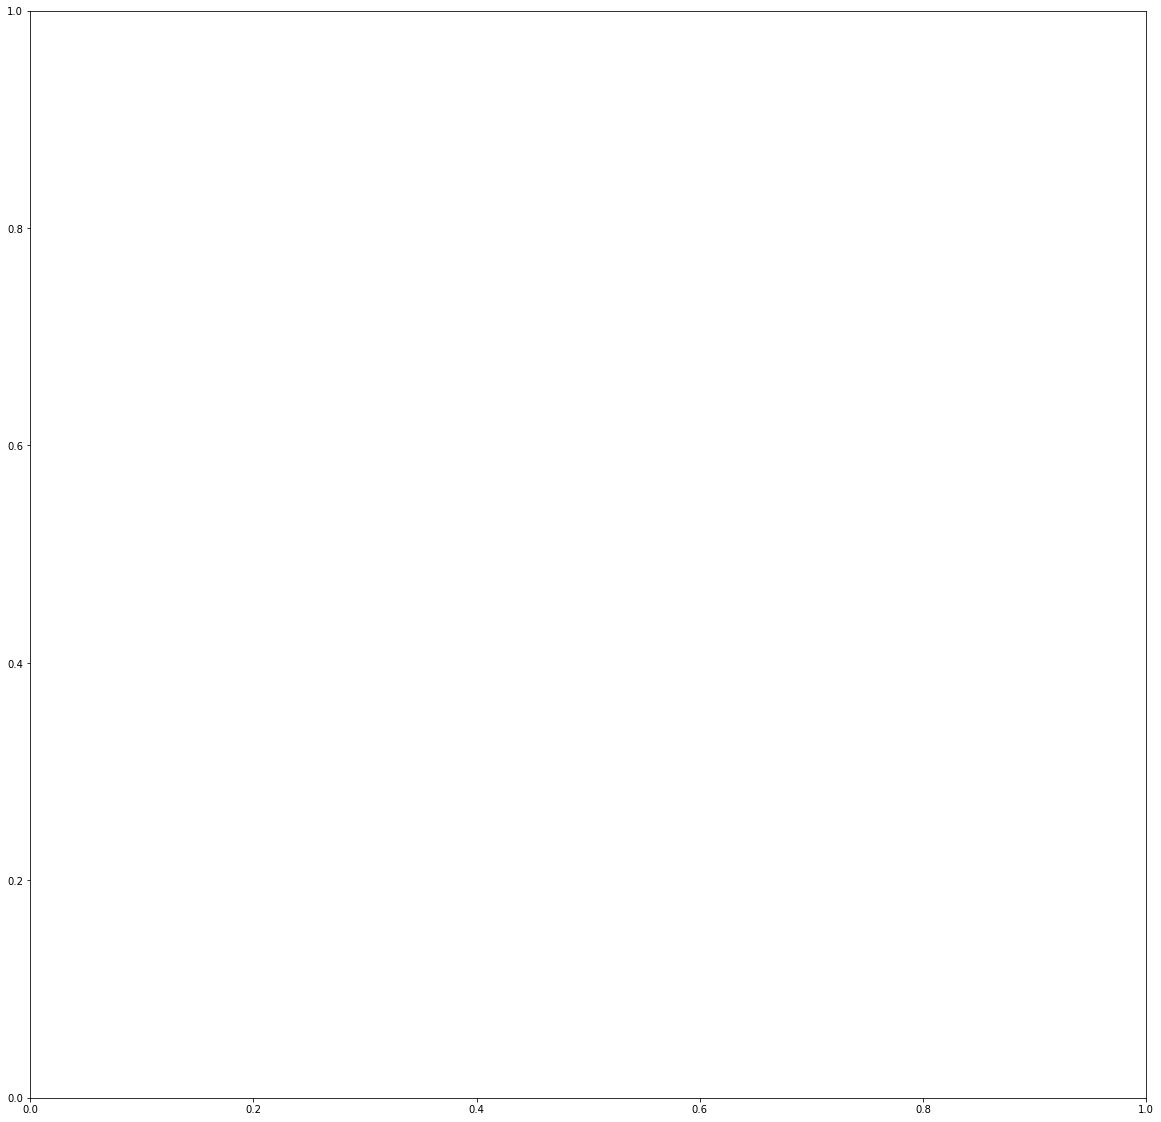

In [12]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(image_raw.img,cmap='gray')
ax.axis(False)

for i_, region_i in enumerate(image_raw.regions):
    box = region_i['bbox']['box']
    if pred[i_][0] == 2:
        poly = patches.Polygon(box,fill=False, edgecolor='green', linewidth=2)
        fc = (0.5, 1, 0.5)
    else :
        poly = patches.Polygon(box,fill=False, edgecolor='red', linewidth=2)
        fc = (1, 0.5, 0.5)
    
    ax.text(
        x=box[0,0] + 8,
        y=box[0,1] + 8,
        s=dict_[pred[i_][0]],
        zorder=0.5,
        size=30,
        ha="left",
        va="top",
        bbox=dict(
            boxstyle="square",
            fc=fc
            )
        )
    ax.add_patch(poly)

In [35]:
def set_seed(seed):
    """ Set the random seed """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def load_config(cfg_path):
    """  """
    if os.path.splitext(cfg_path)[-1] == '.json':
        return AttrDict.from_json_path(cfg_path)
    elif os.path.splitext(cfg_path)[-1] in ['.yaml', '.yml']:
        return AttrDict.from_yaml_path(cfg_path)
    else:
        raise ValueError(f"Unsupported config file format. Only '.json', '.yaml' and '.yml' files are supported.")

def resnet(layers=[3, 4, 6, 3],channels=3, num_classes=1000):
    model = ResNet(BasicBlock,layers,channels=channels,num_classes=num_classes)
    return model

class Classifier(BaseModelSingle):
    def __init__(self, net: nn.Module, opt: Optimizer = None, sched: _LRScheduler = None, 
        logger: Logger = None, print_progress: bool = True, device: str = 'cuda:0', **kwargs):
        super().__init__(net, opt=opt, sched=sched, logger=logger, print_progress=print_progress, device=device, **kwargs)

    def forward_loss(self, data: Tuple[Tensor]) -> Tensor:
        """  """
        pass

    def predict(self, loader):
        """  """
        labels = []
        self.net.eval()
        with torch.no_grad():
            for b, data in enumerate(loader):
                input, label = data
                input = input.to(self.device)
                label = label.to(self.device).long()

                output = self.net(input)
                pred = torch.argmax(output, dim=1)

                labels += list(zip(pred.cpu().data.tolist(), label.cpu().data.tolist()))

            pred, label = zip(*labels)
            
        return pred, label

def main(ifile):
    # Load config_file
    # Read args from terminal
            
    inputs = load_config(ifile)

    # Handle config_file inputs
    seed = int(inputs.Seed)
    layers = inputs.Model.Layers # [3, 4, 6, 3] for ResNet34 and [2, 2, 2, 2] for ResNet18
    classes = inputs.Model.OutClasses
    channels = inputs.Model.Channels

    # Handle file paths
    root_path = os.path.abspath(os.path.join(os.getcwd(), '..')) # Workspace path to Cuttings_Characterisation 
    path_model = f"{root_path}/{inputs.PathSave}/{inputs.ModelName}"
    path_load_data = f"{root_path}/{inputs.LoadPathTestBorehole}" # Path for the .csv file

    # Seed
    set_seed(seed)

    # Pytorch device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    print(torch.cuda.get_device_name(device))

    # Read dataset
    dataframe = pd.read_csv(path_load_data,index_col=0)

    # Transforms (other than MinMaxNorm and ToTensor)
    dict_transform = {
        "Padding":Padding,
        "VerticalFlip":tf.RandomVerticalFlip,
        "HorizontalFlip":tf.RandomHorizontalFlip,
        "Rotation":tf.RandomRotation,
        "CenterCrop":tf.CenterCrop,
        "Resize":tf.Resize,
        }

    transforms_test = Transforms(
        [dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTest.items()] 
        )

    accuracy_scores = []

    model_name = f"model_all.pt"
    save_model_path = f"{path_model}/{model_name}"

    testDataset = Dataset(
        dataframe.reset_index(drop=True),
        transforms=transforms_test.get_transforms()
        )

    test_dataloader = torch.utils.data.DataLoader(
        testDataset, 
        batch_size=4,
        shuffle=False
        )

    net = resnet(layers=layers,channels=channels,num_classes=classes)

    classifier = Classifier(
        net=net, 
        device=device
        )

    classifier.load(save_model_path)

    pred, label = classifier.predict(test_dataloader)

    # Add predictions to the dataframe
    dataframe['preds'] = pred
    dataframe['label'] = label

    accuracy_scores.append(accuracy_score(np.array(label), np.array(pred)))

    dict_acc_scores = {inputs.ModelName : accuracy_scores}

    # if os.path.isfile("test.json"):
    #     with open('test.json', 'r') as openfile:
    #         json_object = json.load(openfile)

    #     for key, value in dict_acc_scores.items():
    #         json_object[key] = value

    #     json_object = json.dumps(json_object, indent = 4)

    #     with open("test.json", "w") as outfile:
    #         outfile.write(json_object)

    # else :
    #     json_object = json.dumps(dict_acc_scores, indent = 4)

    #     with open("test.json", "w") as outfile:
    #         outfile.write(json_object)
    return dataframe

if __name__ == "__main__":
    dataframe = main("../Models/config/MAR_RESNET18_PADDED_256_ALL_NEW.yaml")

cuda:0
NVIDIA GeForce 940MX


In [60]:
# Select one falsely classified image per rock type

df_DB = dataframe.loc[dataframe['preds'] != dataframe['Label'],:].groupby('Label').sample(1,replace=True,random_state=0).reset_index(drop=True)

df_DL = pd.read_csv('../Dataset/train_mar.csv',index_col=0).groupby('Label').sample(1,replace=True,random_state=0).reset_index(drop=True)

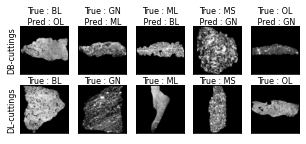

In [70]:
dict_ = {0:'BL',1:'GN',2:'ML',3:'MS',4:'OL'}

transforms = tf.Compose(
        [   
            Padding(out_shape=256),            
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(df_DB,transforms=transforms)
train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=4*5)
train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(2,5,figsize=(5,2))

axs = axs.ravel()

for i_, ax in enumerate(axs[:5]):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    if i_ == 0:
        ax.set_ylabel('DB-cuttings',fontsize=8)
    if i_ == 5:
        ax.set_ylabel('DL-cuttings',fontsize=8)
    if i_ < 5:
        ax.set_title(f"True : {dict_[train_labels.numpy()[i_]]}\n Pred : {dict_[df_DB.iloc[i_]['preds']]}", fontsize=8,pad=2)


trainDataset = Dataset(df_DL,transforms=transforms)
train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=4*5)
train_features, train_labels = next(iter(train_dataloader))

for i_, ax in enumerate(axs[5:]):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    if i_ == 0:
        ax.set_ylabel('DL-cuttings',fontsize=8)
    if i_ < 5:
        ax.set_title(f"True : {dict_[train_labels.numpy()[i_]]}", fontsize=8,pad=2)

plt.savefig('../FiguresPaper/wrong_examples.png',bbox_inches='tight',dpi=1200)